In [3]:
from nbdev import *

# Cell count analysis

In [4]:
# %load common_.py
from common import *

In [5]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [6]:
from pathlib import Path
from ehv import load

In [7]:
df = load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"))

df = load.remove_unwanted_features(df)
df = load.tag_columns(df)

INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C1_T0_49.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C1_T11_55.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C1_T13_56.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C1_T15_57.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C1_T3_50.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C1_T4_51.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C1_T5_52.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C1_T6_53.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C1_T7_54.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C2_T0_58.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C2_T11_64.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C2_T13_65.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C2_T3_59.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C2_T4_60.cif
INFO:ehv.load:/data/weizmann/EhV/high_time_res/Ctrl/C2_T5_61.cif
INFO:ehv.load:/data/

In [7]:
def func(a):
    idx = pandas.read_csv(a, index_col=0, skiprows=1, delimiter="\t").index.values.tolist()
    
    f = a.replace("_ALL", "_COI")
    focused_idx = pandas.read_csv(f, index_col=0, skiprows=1, delimiter="\t").index.values.tolist()
    
    labels = [i in focused_idx for i in idx]
    
    return pandas.DataFrame(
        dict(
            index = idx,
            file = [f]*len(idx),
            coi = labels
        )
    )

with multiprocessing.Pool(processes=12) as pool:
    res = []
    for a in glob.glob(os.path.join(DIR, "**", "*_ALL.txt"), recursive=True):
        res.append((a, pool.apply_async(func, (a,))))
        
    logger.info("Submitted %d" % len(res))

    dfs = []
    for a, r in res:
        dfs.append(r.get())
        logger.info(a)
        
df = pandas.concat(dfs).set_index("index") 

INFO:__main__:Submitted 7
INFO:__main__:/data/newcastle/wbc/data/wbc2_set1_ALL.txt
INFO:__main__:/data/newcastle/wbc/data/wbc2_set2_ALL.txt
INFO:__main__:/data/newcastle/wbc/data/wbc2_set3_ALL.txt
INFO:__main__:/data/newcastle/wbc/data/wbc3_set1_ALL.txt
INFO:__main__:/data/newcastle/wbc/data/wbc3_set2_ALL.txt
INFO:__main__:/data/newcastle/wbc/data/wbc3_set3_ALL.txt
INFO:__main__:/data/newcastle/wbc/data/wbc4_ALL.txt


<AxesSubplot:xlabel='meta_replicate', ylabel='count'>

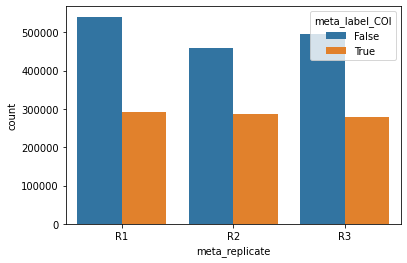

In [9]:
seaborn.countplot(data=df, x="meta_replicate", hue="meta_label_COI")

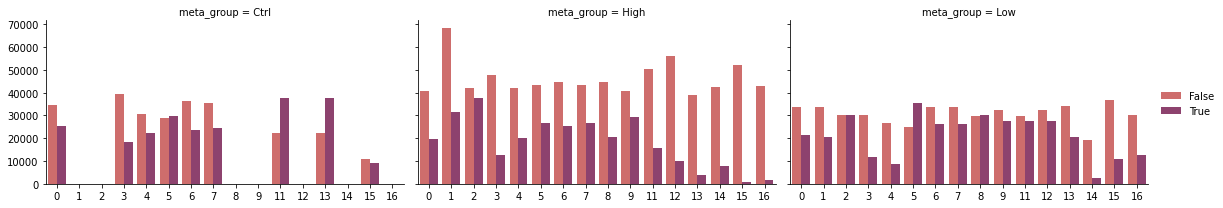

In [36]:
grid = seaborn.FacetGrid(data=df, col="meta_group", aspect=1.8)
grid.map_dataframe(seaborn.countplot, x="meta_timepoint", palette="flare", hue="meta_label_COI", order=sorted(df["meta_timepoint"].unique()))
grid.add_legend()
plt.savefig("figs/data/counts.png", dpi=300, transparent=True, bbox_inches="tight")

In [15]:
timepoint_df = df.groupby("meta_timepoint").sum()
timepoint_df["meta_size"] = df.groupby("meta_timepoint").size()

In [16]:
avg_fraction = (timepoint_df["meta_label_COI"] / timepoint_df["meta_size"]).mean()

In [21]:
avg_fraction

0.3466433554708009

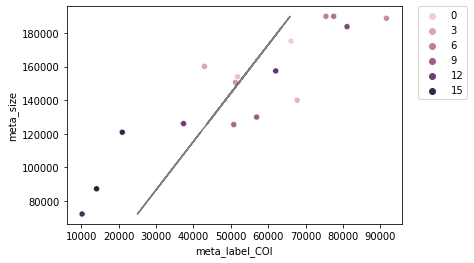

In [20]:
ax = seaborn.scatterplot(data=timepoint_df, x="meta_label_COI", y="meta_size", hue="meta_timepoint")
ax.plot(timepoint_df["meta_size"]*avg_fraction, timepoint_df["meta_size"], color="black", alpha=0.5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)